In [1]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Hyperparameters
IMG_HEIGHT, IMG_WIDTH = 256, 256 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
    
class_indices = {
    'Tomato___Bacterial_spot': 0,
    'Tomato___Early_blight': 1,
    'Tomato___Late_blight': 2,
    'Tomato___Leaf_Mold': 3,
    'Tomato___Septoria_leaf_spot': 4,
    'Tomato___Spider_mites Two-spotted_spider_mite': 5,
    'Tomato___Target_Spot': 6,
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
    'Tomato___Tomato_mosaic_virus': 8,
    'Tomato___healthy': 9
}
num_classes = len(list(class_indices.keys()))

# Define paths
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [3]:
# Data Augmentation and Preprocessing
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0 
    return image, label

#training dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical' 
).map(preprocess).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

#validation dataset
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical'
).map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)

#test dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical'
).map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)


Found 7000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.


In [4]:
# Define CNN Model
cnn_model = Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,202 (453.91 KB)

 Trainable params: 115,722 (452.04 KB)

 Non-trainable params: 480 (1.88 KB)

In [5]:
# Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('cnn_best_model.keras', save_best_only=True, verbose=1)
]

# Train CNN Model
cnn_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.5917 - loss: 1.2188
Epoch 1: val_loss improved from inf to 5.99951, saving model to cnn_best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 97s 413ms/step - accuracy: 0.5922 - loss: 1.2173 - val_accuracy: 0.1120 - val_loss: 5.9995
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8307 - loss: 0.5100
Epoch 2: val_loss improved from 5.99951 to 3.09588, saving model to cnn_best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 87s 397ms/step - accuracy: 0.8308 - loss: 0.5098 - val_accuracy: 0.2730 - val_loss: 3.0959
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8771 - loss: 0.3650
Epoch 3: val_loss improved from 3.09588 to 0.99229, saving model to cnn_best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 87s 398ms/step - accuracy: 0.8771 - loss: 0.3649 - val_accuracy: 0.6890 - val_loss: 0.9923
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9167 - loss: 0.2571
Epoch 4: val_loss did not

In [6]:
# Fine-Tuned ResNet50 Model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
resnet_base.trainable = True

resnet_model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

resnet_callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('resnet_best_model.keras', save_best_only=True, verbose=1)
]

# Train ResNet50 Model
resnet_history = resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=resnet_callbacks
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6163 - loss: 1.2545
Epoch 1: val_loss improved from inf to 12.69355, saving model to resnet_best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 891s 4s/step - accuracy: 0.6168 - loss: 1.2528 - val_accuracy: 0.1000 - val_loss: 12.6935
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8754 - loss: 0.4065
Epoch 2: val_loss did not improve from 12.69355
219/219 ━━━━━━━━━━━━━━━━━━━━ 861s 4s/step - accuracy: 0.8754 - loss: 0.4063 - val_accuracy: 0.1000 - val_loss: 22.0125
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9195 - loss: 0.2550
Epoch 3: val_loss improved from 12.69355 to 8.36465, saving model to resnet_best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 866s 4s/step - accuracy: 0.9196 - loss: 0.2550 - val_accuracy: 0.1000 - val_loss: 8.3647
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9474 - loss: 0.1778
Epoch 4: val_loss did not improve from 8.36465
219/219 ━━━━━━━━━━━━━━━━━━━

In [7]:
# Save Models
cnn_model.save('cnn_model.keras')
resnet_model.save('resnet50_model.keras')

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9628 - loss: 0.1174
CNN Test Accuracy: 0.96

Accuracy: 0.9627
Precision: 0.9627
Recall: 0.9627
F1-Score: 0.9625
ROC-AUC: 0.9989

CNN Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.98      0.98      0.98       300
                        Tomato___Early_blight       0.95      0.96      0.95       300
                         Tomato___Late_blight       0.95      0.90      0.92       300
                           Tomato___Leaf_Mold       0.98      0.96      0.97       300
                  Tomato___Septoria_leaf_spot       0.97      0.97      0.97       300
Tomato___Spider_mites Two-spotted_spider_mite       0.93      0.97      0.95       300
                         Tomato___Target_Spot       0.96      0.91      0.93       300
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.98      0.98       300
      

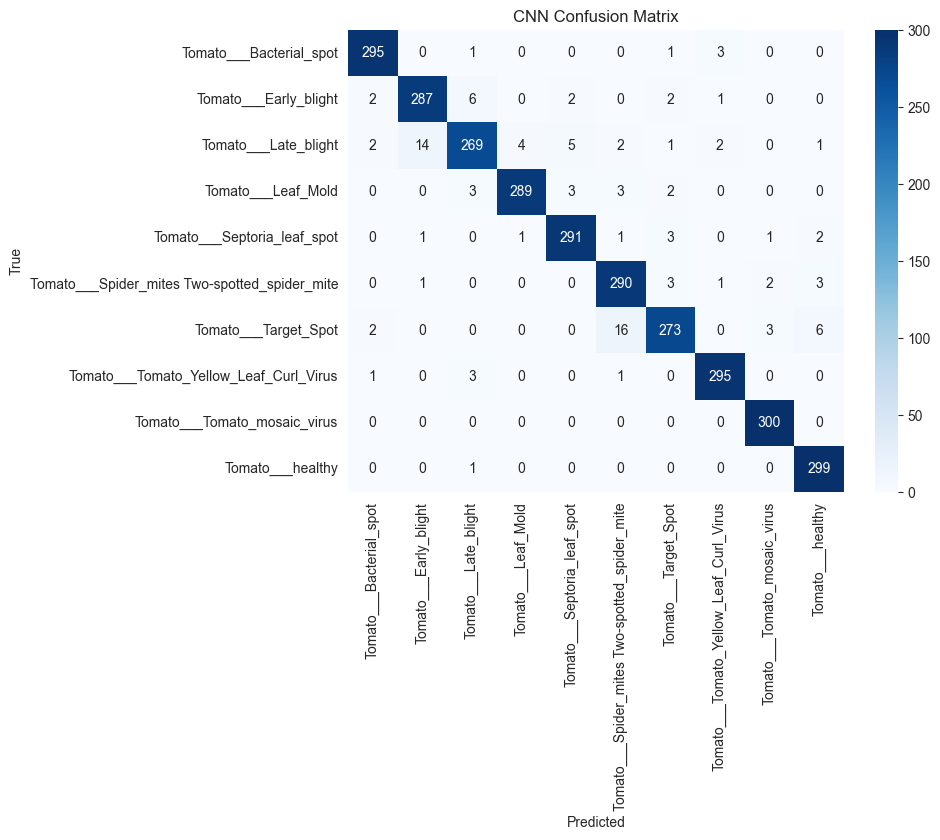

94/94 ━━━━━━━━━━━━━━━━━━━━ 76s 809ms/step - accuracy: 0.9106 - loss: 0.3470
ResNet50 Test Accuracy: 0.91

Accuracy: 0.9127
Precision: 0.9231
Recall: 0.9127
F1-Score: 0.9123
ROC-AUC: 0.9965

ResNet50 Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.99      0.92      0.95       300
                        Tomato___Early_blight       0.87      0.89      0.88       300
                         Tomato___Late_blight       0.88      0.98      0.93       300
                           Tomato___Leaf_Mold       0.88      0.99      0.93       300
                  Tomato___Septoria_leaf_spot       0.99      0.79      0.88       300
Tomato___Spider_mites Two-spotted_spider_mite       0.96      0.89      0.93       300
                         Tomato___Target_Spot       0.74      0.96      0.83       300
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.99      0.98     

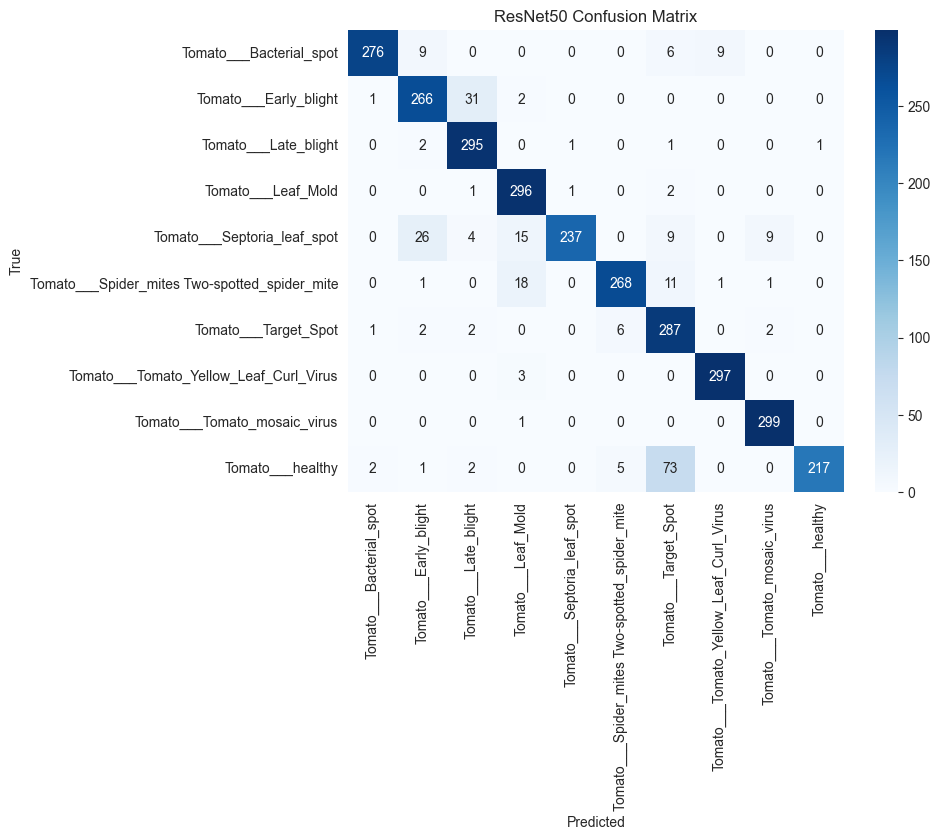

In [8]:
# Evaluate Model Function
def evaluate_model(model, data, class_indices, model_name="Model"):
    loss, accuracy = model.evaluate(data)
    print(f"{model_name} Test Accuracy: {accuracy:.2f}\n")
    
    y_true = []
    y_pred = []
    predictions = []

    for images, labels in data:
        preds = model.predict(images, verbose=0)
        predictions.extend(preds) 
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
    predictions = np.array(predictions)

    # Evaluation Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    roc_auc = roc_auc_score(y_true_bin, predictions, multi_class='ovr')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Classification Metrics
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(class_indices.keys()),
                yticklabels=list(class_indices.keys()))
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Evaluate All Models
evaluate_model(cnn_model, test_data, class_indices, "CNN")
evaluate_model(resnet_model, test_data, class_indices, "ResNet50")

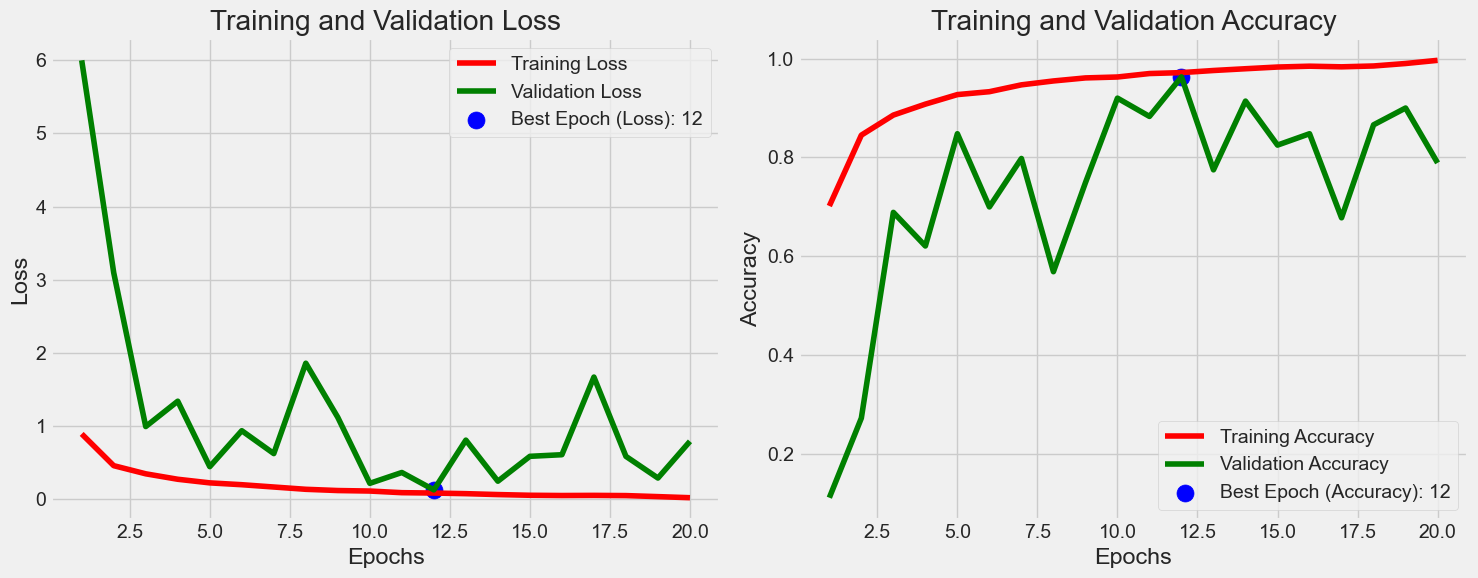

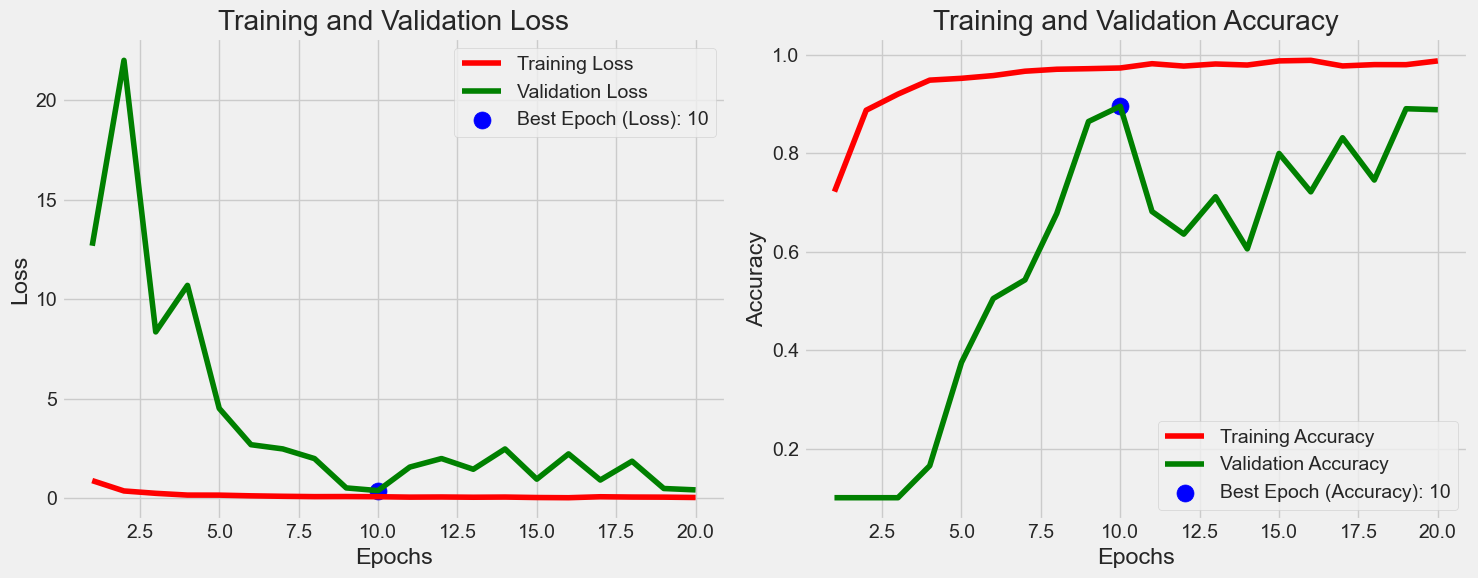

In [9]:
def tr_plot(tr_data, start_epoch):
    train_acc = tr_data.history['accuracy']
    train_loss = tr_data.history['loss']
    val_acc = tr_data.history['val_accuracy']
    val_loss = tr_data.history['val_loss']

    total_epochs = len(train_acc) + start_epoch
    epochs = list(range(start_epoch + 1, total_epochs + 1))

    best_val_loss_epoch = np.argmin(val_loss) 
    best_val_loss = val_loss[best_val_loss_epoch]

    best_val_acc_epoch = np.argmax(val_acc) 
    best_val_acc = val_acc[best_val_acc_epoch]

    plt.style.use('fivethirtyeight')
    loss_label = f"Best Epoch (Loss): {best_val_loss_epoch + 1 + start_epoch}"
    acc_label = f"Best Epoch (Accuracy): {best_val_acc_epoch + 1 + start_epoch}"
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # training and validation loss
    axes[0].plot(epochs, train_loss, 'r', label='Training Loss')
    axes[0].plot(epochs, val_loss, 'g', label='Validation Loss')
    axes[0].scatter(best_val_loss_epoch + 1 + start_epoch, best_val_loss, s=150, c='blue', label=loss_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # training and validation accuracy
    axes[1].plot(epochs, train_acc, 'r', label='Training Accuracy')
    axes[1].plot(epochs, val_acc, 'g', label='Validation Accuracy')
    axes[1].scatter(best_val_acc_epoch + 1 + start_epoch, best_val_acc, s=150, c='blue', label=acc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

tr_plot(cnn_history, 0)
tr_plot(resnet_history, 0)